## Anomaly Detection for Córrego do Feijão dam in Brumadinho-MG
#### Period: 2013 to 2020;
#### Tools: Google Earth Engine Python API, Sentinel Images, Pandas, Numpy, Scikit-Learn.

In [1]:
import ee
from osgeo import gdal
from osgeo import osr
import pandas as pd
import numpy as np
import time

#from save_gee_image_tiff import save_gee_tiff
ee.Initialize()

- Select coordinates and build our ImageCollection;

Sentinel Multispectral Images have 10 meters of spatial resolution and 16 bands.

In [2]:
coordenadas = "-44.13576882693976,-20.14040952973489,-44.107444699742494,-20.11204199216084"
x1,y1,x2,y2 = coordenadas.split(",")
geometria = geometry = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])
datas = "2013-01-01,2021-12-31"
inicio,fim = datas.split(",")
colecao = ee.ImageCollection('COPERNICUS/S2').filterBounds(geometria).filterDate(inicio,fim).filterMetadata('CLOUD_COVERAGE_ASSESSMENT','less_than', 0.5)
print("Total de imagens encontradas: "+str(colecao.size().getInfo()))

Total de imagens encontradas: 67


- Band selection and Vegetation Indexes apply (NDVI and NDWI)

In [3]:
blue = 'B2'; green = 'B3'; red = 'B4'; nir = 'B8'

def ndvi(imagem):
    ndvi = imagem.expression('(nir - red) / (nir + red)',{'nir':imagem.select(nir),'red':imagem.select(red)}).rename('ndvi')
    return imagem.addBands(ndvi)

def ndwi(imagem):
    ndwi = imagem.expression('(nir - green) / (nir + green)',{'nir':imagem.select(nir),'green':imagem.select(green)}).rename('ndwi')
    return imagem.addBands(ndwi)

colecao = colecao.map(ndvi)
colecao = colecao.map(ndwi)
imagem = colecao.median()
print(imagem.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'ndvi', 'ndwi']


- Reduce function building and passing band values to Pandas DataFrame

In [4]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=30,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [5]:
reduce_ndvi = create_reduce_region_function(
    geometry=geometria, reducer=ee.Reducer.mean(), scale=10)

ndvi_stat_fc = ee.FeatureCollection(colecao.map(reduce_ndvi)).filter(
    ee.Filter.notNull(colecao.first().bandNames()))

ndvi_dict = fc_to_dict(ndvi_stat_fc).getInfo()
ndvi_df = pd.DataFrame(ndvi_dict)
display(ndvi_df)
print(ndvi_df.dtypes)

B1        B10          B11         B12           B2          B3  \
0   1054.163385   7.788523  1252.021543  597.734265   796.995766  686.484956   
1   1139.365383   9.756406  1261.974753  681.122149   869.799419  731.353093   
2   1139.365383   9.756406  1261.974753  681.122149   869.799419  731.353093   
3   1020.224428   7.952273  1244.479792  649.650043   763.291003  643.622304   
4   1020.224428   7.952273  1244.479792  649.650043   763.291003  643.622304   
..          ...        ...          ...         ...          ...         ...   
62  1040.292823  10.332857  1417.033442  830.090995   793.425018  694.582552   
63  1066.367218  10.269012  1438.373410  896.487707   820.634639  724.916002   
64  1055.821878   8.174025  1486.446858  920.870684   810.631446  724.672706   
65  1262.010278  11.675924  1550.782924  933.254815  1000.354351  874.287734   
66  1093.092459  10.330787  1504.913997  841.248428   853.509351  776.215847   

            B4           B5           B6           B7           B8  \
0   514.794929   731.634645  1594.863498  1932.370190  1833.826146   
1   573.733059   778.292151  1541.377042  1821.318453  1770.286909   
2   573.733059   778.292151  1541.377042  1821.318453  1770.286909   
3   511.936307   706.347733  1403.120414  1665.751060  1597.719413   
4   511.936307   706.347733  1403.120414  1665.751060  1597.719413   
..         ...          ...          ...          ...          ...   
62  638.385320   843.936572  1416.572569  1627.392717  1577.700696   
63  682.677135   875.792341  1406.489210  1615.975562  1571.205526   
64  695.302648   883.000701  1421.233879  1650.723398  1564.844482   
65  827.111458  1000.530293  1526.055755  1738.723969  1636.887376   
66  689.306669   925.579250  1622.947678  1890.311025  1791.581538   

            B8A          B9  QA10  QA20  QA60         millis      ndvi  \
0   2081.776517  445.580254     0     0   0.0  1462626880000  0.543902   
1   1958.824814  655.361676     0     0   0.0  1466082765460  0.505170   
2   1958.824814  655.361676     0     0   0.0  1466082765463  0.505170   
3   1791.469920  487.561920     0     0   0.0  1467810949453  0.501594   
4   1791.469920  487.561920     0     0   0.0  1467810949453  0.501594   
..          ...         ...   ...   ...   ...            ...       ...   
62  1746.916642  602.478069     0     0   0.0  1629379074232  0.421084   
63  1739.964677  588.126083     0     0   0.0  1629811070469  0.394416   
64  1774.556316  421.598691     0     0   0.0  1630675068417  0.386259   
65  1847.461167  463.342087     0     0   0.0  1631107072097  0.325697   
66  2025.204623  471.230443     0     0   0.0  1632835075954  0.428815   

        ndwi                            system:index  
0   0.432983  20160507T131252_20160507T131440_T23KNT  
1   0.397767  20160616T131242_20160616T131245_T23KNT  
2   0.397767  20160616T131245_20160616T193218_T23KNT  
3   0.403228  20160706T131242_20160706T131549_T23KNT  
4   0.403228  20160706T131549_20160706T194917_T23KNT  
..       ...                                     ...  
62  0.371945  20210819T131251_20210819T131520_T23KNT  
63  0.355271  20210824T131039_20210824T131536_T23KNT  
64  0.353543  20210903T131039_20210903T131509_T23KNT  
65  0.293670  20210908T131041_20210908T131317_T23KNT  
66  0.374524  20210928T131051_20210928T131740_T23KNT  

[67 rows x 20 columns]

B1              float64
B10             float64
B11             float64
B12             float64
B2              float64
B3              float64
B4              float64
B5              float64
B6              float64
B7              float64
B8              float64
B8A             float64
B9              float64
QA10              int64
QA20              int64
QA60            float64
millis            int64
ndvi            float64
ndwi            float64
system:index     object
dtype: object


In [6]:
ndvi_df = add_date_info(ndvi_df)
ndvi_df.tail(5)

B1        B10          B11         B12           B2          B3  \
62  1040.292823  10.332857  1417.033442  830.090995   793.425018  694.582552   
63  1066.367218  10.269012  1438.373410  896.487707   820.634639  724.916002   
64  1055.821878   8.174025  1486.446858  920.870684   810.631446  724.672706   
65  1262.010278  11.675924  1550.782924  933.254815  1000.354351  874.287734   
66  1093.092459  10.330787  1504.913997  841.248428   853.509351  776.215847   

            B4           B5           B6           B7  ...  QA60  \
62  638.385320   843.936572  1416.572569  1627.392717  ...   0.0   
63  682.677135   875.792341  1406.489210  1615.975562  ...   0.0   
64  695.302648   883.000701  1421.233879  1650.723398  ...   0.0   
65  827.111458  1000.530293  1526.055755  1738.723969  ...   0.0   
66  689.306669   925.579250  1622.947678  1890.311025  ...   0.0   

           millis      ndvi      ndwi                            system:index  \
62  1629379074232  0.421084  0.371945  20210819T131251_20210819T131520_T23KNT   
63  1629811070469  0.394416  0.355271  20210824T131039_20210824T131536_T23KNT   
64  1630675068417  0.386259  0.353543  20210903T131039_20210903T131509_T23KNT   
65  1631107072097  0.325697  0.293670  20210908T131041_20210908T131317_T23KNT   
66  1632835075954  0.428815  0.374524  20210928T131051_20210928T131740_T23KNT   

                 Timestamp  Year  Month  Day  DOY  
62 2021-08-19 13:17:54.232  2021      8   19  231  
63 2021-08-24 13:17:50.469  2021      8   24  236  
64 2021-09-03 13:17:48.417  2021      9    3  246  
65 2021-09-08 13:17:52.097  2021      9    8  251  
66 2021-09-28 13:17:55.954  2021      9   28  271  

[5 rows x 25 columns]

## NDWI Application
NDWI = Normalized Difference Water Index

In [7]:
import altair as alt
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

base = alt.Chart(ndvi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y('ndvi:Q', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('ndvi:Q', title='NDVI')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

(points + lines).properties(width=600, height=350).interactive()

alt.LayerChart(...)

In [8]:
base = alt.Chart(ndvi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(0, 360))))

line = base.mark_line().encode(
    y=alt.Y('median(ndvi):Q', scale=alt.Scale(domain=(0, 1))))

band = base.mark_errorband(extent='iqr').encode(
    y='ndvi:Q')

(line + band).properties(width=600, height=300).interactive()

alt.LayerChart(...)

- Median subtraction to get the best central trend

In [9]:
listaColecao = colecao.toList(colecao.size())
lista_sm = ee.List([])
for im in range(colecao.size().getInfo()):
    sub_med = ee.Image(listaColecao.get(im)).subtract(imagem)
    lista_sm = lista_sm.add(sub_med)
    
col_ajust = ee.ImageCollection(lista_sm)

- Function to extract pixel values for a Numpy Array

In [10]:
def ext_lat_lon_pixel10(image, geometria, bandas):
    image = image.addBands(ee.Image.pixelLonLat())
    coordenadas = image.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=10,bestEffort=True)
    bandas_valores = []
    for banda in bandas:
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))

    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

#### DataFrame construction!
- Dates x Lat/Lon

In [12]:
listaCN = col_ajust.toList(col_ajust.size())
defaultDummy = -99999
df_r10 = pd.DataFrame()
dias = ndvi_df['Timestamp'].values
di = {}
for j in range(col_ajust.size().getInfo()):
    tempndvi = dias[j]
    img = ee.Image(defaultDummy).blend(ee.Image(listaCN.get(j)))
    lat10, lon10, ind10 = ext_lat_lon_pixel10(img,geometria,['ndwi'])
    di[tempndvi] = ind10[0]
    
df_r10 = df_r10.from_dict(di)
df_r10 = df_r10.assign(Latitude = lat10)
df_r10 = df_r10.assign(Longitude = lon10)
df_r10 = df_r10.set_index(['Latitude','Longitude'])
df_r10

2016-05-07 13:14:40.000  2016-06-16 13:12:45.460  \
Latitude   Longitude                                                      
-20.140363 -44.135712                 0.054876                -0.259708   
           -44.135622                 0.015994                -0.259750   
           -44.135532                 0.032945                -0.203082   
           -44.135443                 0.032945                -0.203082   
           -44.135353                 0.024021                -0.219113   
...                                        ...                      ...   
-20.112066 -44.107864                 0.019649                -0.018953   
           -44.107775                 0.003584                -0.007695   
           -44.107685                 0.012209                 0.000664   
           -44.107595                -0.009807                -0.052863   
           -44.107505                 0.078098                -0.028794   

                       2016-06-16 13:12:45.463  2016-07-06 13:15:49.453  \
Latitude   Longitude                                                      
-20.140363 -44.135712                -0.259708                 0.011354   
           -44.135622                -0.259750                 0.018813   
           -44.135532                -0.203082                 0.034284   
           -44.135443                -0.203082                 0.034284   
           -44.135353                -0.219113                 0.027317   
...                                        ...                      ...   
-20.112066 -44.107864                -0.018953                -0.007819   
           -44.107775                -0.007695                 0.011974   
           -44.107685                 0.000664                 0.008195   
           -44.107595                -0.052863                -0.025515   
           -44.107505                -0.028794                -0.011610   

                       2016-07-26 13:12:46.455  2016-09-04 13:14:48.730  \
Latitude   Longitude                                                      
-20.140363 -44.135712             1.874842e-02                -0.038332   
           -44.135622             2.158005e-03                -0.031309   
           -44.135532             6.672791e-03                -0.022198   
           -44.135443             6.672791e-03                -0.022198   
           -44.135353             5.849400e-09                -0.015846   
...                                        ...                      ...   
-20.112066 -44.107864             2.911888e-03                 0.027270   
           -44.107775             1.038469e-02                 0.023735   
           -44.107685            -7.427261e-03                 0.044345   
           -44.107595            -4.287183e-02                 0.005683   
           -44.107505            -8.866675e-03                 0.012507   

                       2017-07-01 13:16:32.360  2017-08-30 13:12:42.460  \
Latitude   Longitude                                                      
-20.140363 -44.135712                 0.023547                -0.020031   
           -44.135622                 0.048327                -0.038421   
           -44.135532                 0.014796                -0.059228   
           -44.135443                 0.014796                -0.059228   
           -44.135353                 0.027238                -0.063160   
...                                        ...                      ...   
-20.112066 -44.107864                -0.066052                -0.016082   
           -44.107775                -0.053082                -0.052455   
           -44.107685                -0.070116                -0.048862   
           -44.107595                -0.089063                -0.077147   
           -44.107505                -0.062468                -0.074509   

                       2017-09-04 13:12:36.460  2017-10-14 13:16:26.570  ...  \
Latitude   Longitude                   

## Machine Learning Anomaly Detection methods application

### One Class SVM
At this point, we have to optimize our training dataset. For that, we put a proportional bound ($\alpha$) to the standard deviation of mean, to extract the most likely probable values.

- Vectorizing the DataFrames values to calculate the mean and standard deviation

In [13]:
oc_val = df_r10.values.reshape(-1,1)
dpoc = np.std(oc_val)
meanoc = np.mean(oc_val)
print(dpoc, meanoc)

0.09735056121495719 0.0028525278154192106


- Input $\alpha$ value to optimize the dataset, returning one regular array:
-- upper bound = $mean + \alpha*std$
-- lower bound = $mean - \alpha*std$
-- array_reg = [lower bound:upper bound]

In [27]:
listareg = []
alpha = 1 #float(input('digite o valor de alpha: '))
inf_lim = meanoc - alpha*dpoc
sup_lim = meanoc + alpha*dpoc
for i in oc_val:
    if inf_lim < i < sup_lim:
        listareg.append(i)
        
array_reg = np.asarray(listareg)
len(array_reg)

5024870

- Input $\beta$ value to reduce the array size and optimize One-Class SVM method

In [28]:
beta = 0.01 #float(input('digite o valor de beta: '))
novo_data = int(beta * len(array_reg))
dataind = np.random.choice(len(array_reg),size=novo_data)
dataset = array_reg[dataind]
len(dataset)

502487

- Statistic functions:
    - transitions -> 1 to -1 or -1 to 1 (== changes);
    - mantem_normal -> 1 to 1;
    - mantem_anomalia -> -1 to -1;
    - contador_reg -> count all regular pixels;
    - contador_anomaly -> count all anomaly pixels;
    - p_valor -> calculate the p-value of changes;

In [16]:
def transitions(df):
    diff = df + df.shift(1)
    zero = (diff == 0).astype(int).sum()
    return zero

def mantem_normal(df):
    soma = df + df.shift(1)
    dois = (soma == 2).astype(int).sum()
    return dois

def mantem_anomalia(df):
    soma = df + df.shift(1)
    dois = (soma == -2).astype(int).sum()
    return dois

def contador_reg(df):
    return (df == 1).astype(int).sum()

def contador_anomaly(df):
    return (df == -1).astype(int).sum()

from scipy import stats
from statistics import NormalDist
def p_valor(df):
    return 1 - NormalDist().cdf(df)

- Define the function <strong>OCSVM</strong> to map in DataDrame

In [17]:
def save_tiff_fromdf(df,bands,dummy,path_out):
    
    lat = []
    lon = []
    for i in range(len(df)):
        lat.append(df.index[i][0])
        lon.append(df.index[i][1])
    
    
    ulat = np.unique(lat)
    ulon = np.unique(lon)
    ncols = len(ulon)
    nrows = len(ulat)
    nbands = len(bands)
    ys = ulat[11]-ulat[10]
    xs = ulon[11]-ulon[10]
    
    arr = np.zeros([nbands, nrows, ncols], np.float32)
    refLat = np.max(ulat)
    refLon = np.min(ulon)
    for j in range(len(df)):
        posLin = np.int64( np.round( (refLat - lat[j])/ys ) )
        posCol = np.int64( np.round( (lon[j] - refLon)/xs ) )
        for b in range(nbands):
            arr[b,posLin,posCol] = df.loc[df.index[j],bands[b]]
            
    transform = (np.min(ulon),xs,0,np.max(ulat),0,-ys)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)
    
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(path_out,ncols,nrows,nbands,gdal.GDT_Float32)
    outDs.SetGeoTransform(transform)
    outDs.SetProjection(target.ExportToWkt())

    ind = 1
    for b in range(nbands):
        bandArr = np.copy(arr[b,:,:])
        outBand = outDs.GetRasterBand(ind)
        outBand.WriteArray(bandArr)
        outBand.FlushCache()
        outBand.SetNoDataValue(dummy)
        ind += 1

    outDs = None
    del outDs, outBand

    return 'ok...'

In [18]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.svm import OneClassSVM

def OCSVM(df, occlf):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

def cria_dataf(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = OCSVM(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

def Aplica_Metricas(x):
    tabela_de_testes = x
    tab_stats_oc = pd.DataFrame()
    tab_stats_oc.loc[:,'Anomalias'] = tabela_de_testes.apply(contador_anomaly, axis=1)
    tab_stats_oc.loc[:,'Regular'] = tabela_de_testes.apply(contador_reg, axis=1)
    tab_stats_oc.loc[:,'Mudanças'] = tabela_de_testes.apply(transitions, axis=1)
    tab_stats_oc.loc[:,'Permanece Regular'] = tabela_de_testes.apply(mantem_normal, axis=1)
    tab_stats_oc.loc[:,'Permanece Anomalia'] = tabela_de_testes.apply(mantem_anomalia, axis=1)
    ano = tab_stats_oc['Anomalias']; reg = tab_stats_oc['Regular']; mud = tab_stats_oc['Mudanças']
    media = np.mean(mud)
    stdev = np.std(mud)
    tab_stats_oc.loc[:,'media'] = media
    tab_stats_oc.loc[:,'std'] = stdev
    tab_stats_oc.loc[:,'z'] = (mud - media)/stdev
    tab_stats_oc.loc[:,'p-valor'] = tab_stats_oc.loc[:,'z'].apply(p_valor)
    return tab_stats_oc

In [ ]:
nuu = [0.001, 0.005, 0.01, 0.05, 0.1]
metric_dict = {}
data_dict = {}
dummy = -99999
bands = ['Anomalias','p-valor']
for i in nuu:
    classificador = OneClassSVM(nu=i, kernel='rbf', gamma='auto').fit(array_reg)
    tab_ex = cria_dataf(df_r10, classificador)
    data_dict[i] = tab_ex
    tab_res = Aplica_Metricas(tab_ex)
    metric_dict[i] = tab_res
    path_out = 'Tiff/V4_Out_22/Brumadinho_NDWI_OCSVM_' + str(i) + '.tif'
    save_tiff_fromdf(tab_res,bands,dummy,path_out)
    print(i)

#### Plotting the distribution of p-values and anomalies

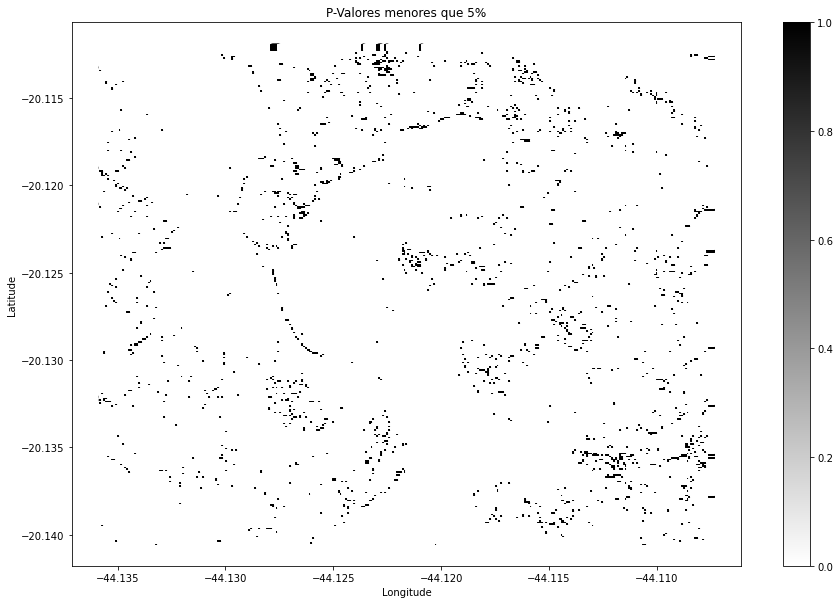

In [21]:
import matplotlib.pyplot as plt
filtro_oc = tab_stats_oc.copy()
filtro_oc.loc[tab_stats_oc['p-valor']>0.05,'p-valor'] = 0
filtro_oc.loc[tab_stats_oc['p-valor']<0.05,'p-valor'] = 1
x = filtro_oc.index.get_level_values(1).values
y = filtro_oc.index.get_level_values(0).values

mask1 = filtro_oc['p-valor'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask1,cmap='binary')
ax.set_title('P-Valores menores que 5%')
plt.colorbar(ax.scatter(x,y,c=mask1,marker=',',cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_OC_pval.png')
plt.show()

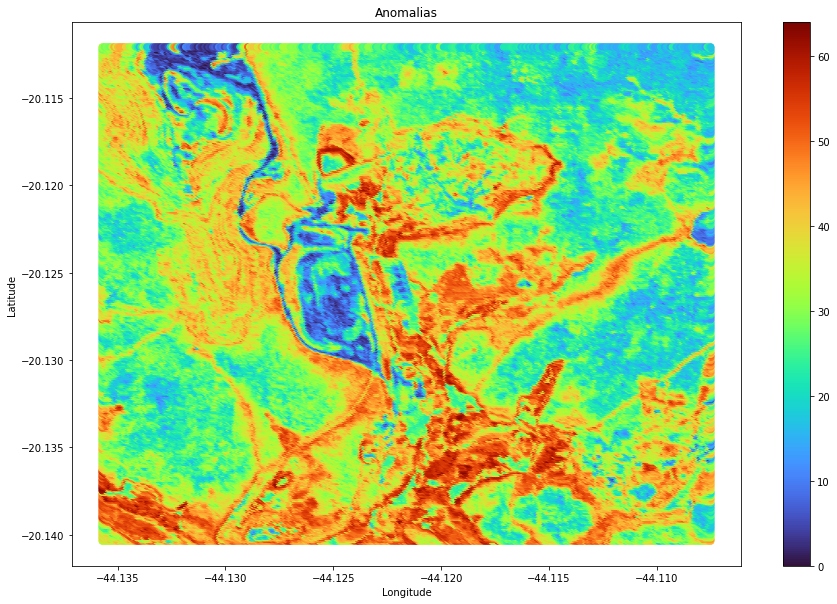

In [22]:
mask1 = tab_stats_oc['Anomalias'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask1,cmap='turbo')
ax.set_title('Anomalias')
plt.colorbar(ax.scatter(x,y,c=mask1,cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_OC_anom.png')
plt.show()

### Isolation Forest
#### Median subtraction and Anomaly detection based on regular dataset

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

def isola(df, occlf):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

def cria_dataf_2(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = isola(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

In [29]:
data_dict_if = {}
metric_dict_if = {}
bands = ['Anomalias','p-valor']
dummy = -99999
for i in range(5):
    valor = 20 + i*20
    classificador = IsolationForest(n_estimators=valor,n_jobs=-1).fit(array_reg)
    
    tab_ex = cria_dataf_2(df_r10, classificador)
    data_dict_if[i] = tab_ex
    tab_res = Aplica_Metricas(tab_ex)
    metric_dict_if[i] = tab_res
    path_out = 'Tiff/V4_Out_22/Brumadinho_NDWI_IF_' + str(valor) + '.tif'
    save_tiff_fromdf(tab_res,bands,dummy,path_out)
    print(i)

0
1
2
3
4


#### Plotting the distribution of p-values and anomalies

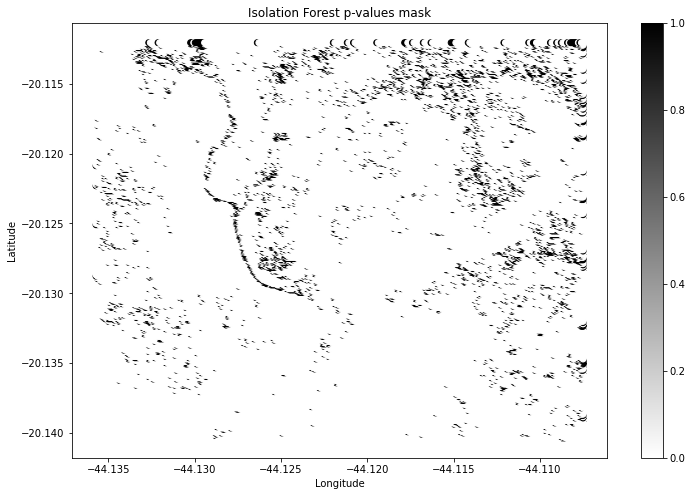

In [29]:
import matplotlib.pyplot as plt
filtro = tab_stats.copy()
filtro.loc[tab_stats['p-valor']>0.05,'p-valor'] = 0
filtro.loc[tab_stats['p-valor']<0.05,'p-valor'] = 1
y = filtro.index.get_level_values(0).values
x = filtro.index.get_level_values(1).values
mask1 = filtro['p-valor'].values
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,c=mask1,marker=',',cmap='binary')
ax.set_title('Isolation Forest p-values mask')
plt.colorbar(ax.scatter(x,y,c=mask1,cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru10_NDVIIFpvalues.png')
plt.show()

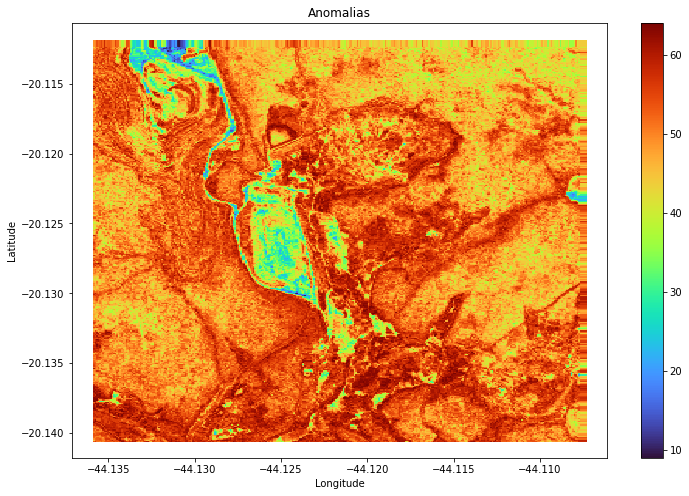

In [30]:
mask = tab_stats['Anomalias'].values
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,c=mask,marker=',',cmap='turbo')
ax.set_title('Anomalias')
plt.colorbar(ax.scatter(x,y,c=mask,marker=',',cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru10_NDVIIFanomalias.png')
plt.show()

### Isolation Forest
#### Median subtraction and Anomaly detection based on entire dataset

In [31]:
classificador2 = IsolationForest(n_estimators=40,random_state=0,
                                n_jobs=-1,max_samples='auto').fit(oc_val)
def isola2(df):
    x = df.to_numpy().reshape(-1,1)
    res = classificador2.predict(x)
    ser = pd.Series(res, index=df.index)
    return ser

In [32]:
tabela_de_testes_if = pd.DataFrame(index = df_r10.index, columns = df_r10.columns)
tabela_de_testes_if = tabela_de_testes_if.append(df_r10.apply(isola2, axis=1), ignore_index=False).dropna()
tabela_de_testes_if.tail()

2016-05-07 13:14:40.000 2016-06-16 13:12:45.460  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2016-06-16 13:12:45.463 2016-07-06 13:15:49.453  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2016-07-26 13:12:46.455 2016-09-04 13:14:48.730  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2017-07-01 13:16:32.360 2017-08-30 13:12:42.460  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2017-09-04 13:12:36.460 2017-10-14 13:16:26.570  ...  \
Latitude   Longitude                                                   ...   
-20.112066 -44.107864                       1                       1  ...   
           -44.107775                       1                       1  ...   
           -44.107685                       1                       1  ...   
           -44.107595                      -1                       1  ...   
           -44.107505                       1                       1  ...   

                      2021-06-15 13:17:52.861 2021-06-25 13:17:52.413  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2021-07-10 13:17:54.848 2021-07-25 13:17:53.875  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2021-08-14 13:17:52.105 2021-08-19 13:17:54.232  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                      -1                       1   
           -44.107685                       1                       1   
           -44.107595                 

In [33]:
tab_stats_if = pd.DataFrame()
tab_stats_if.loc[:,'Anomalias'] = tabela_de_testes_if.apply(contador_anomaly, axis=1)
tab_stats_if.loc[:,'Regular'] = tabela_de_testes_if.apply(contador_reg, axis=1)
tab_stats_if.loc[:,'Mudanças'] = tabela_de_testes_if.apply(transitions, axis=1)
tab_stats_if.loc[:,'Permanece Regular'] = tabela_de_testes_if.apply(mantem_normal, axis=1)
tab_stats_if.loc[:,'Permanece Anomalia'] = tabela_de_testes_if.apply(mantem_anomalia, axis=1)
ano = tab_stats_if['Anomalias']; reg = tab_stats_if['Regular']; mud = tab_stats_if['Mudanças']
media = np.mean(mud)
stdev = np.std(mud)
tab_stats_if.loc[:,'media'] = media
tab_stats_if.loc[:,'std'] = stdev
tab_stats_if.loc[:,'z'] = (mud - media)/stdev
tab_stats_if.loc[:,'p-valor'] = tab_stats_if.loc[:,'z'].apply(p_valor)
tab_stats_if

Anomalias  Regular  Mudanças  Permanece Regular  \
Latitude   Longitude                                                     
-20.140363 -44.135712         11       54        16                 45   
           -44.135622         12       53        18                 43   
           -44.135532         12       53        12                 46   
           -44.135443         12       53        12                 46   
           -44.135353         14       51        16                 42   
...                          ...      ...       ...                ...   
-20.112066 -44.107864          1       64         2                 62   
           -44.107775          2       63         4                 60   
           -44.107685          2       63         4                 60   
           -44.107595          3       62         6                 58   
           -44.107505          3       62         6                 58   

                       Permanece Anomalia      media       std         z  \
Latitude   Longitude                                                       
-20.140363 -44.135712                   3  10.764215  5.383644  0.972535   
           -44.135622                   3  10.764215  5.383644  1.344031   
           -44.135532                   6  10.764215  5.383644  0.229544   
           -44.135443                   6  10.764215  5.383644  0.229544   
           -44.135353                   6  10.764215  5.383644  0.972535   
...                                   ...        ...       ...       ...   
-20.112066 -44.107864                   0  10.764215  5.383644 -1.627934   
           -44.107775                   0  10.764215  5.383644 -1.256438   
           -44.107685                   0  10.764215  5.383644 -1.256438   
           -44.107595                   0  10.764215  5.383644 -0.884942   
           -44.107505                   0  10.764215  5.383644 -0.884942   

                        p-valor  
Latitude   Longitude             
-20.140363 -44.135712  0.165392  
           -44.135622  0.089469  
           -44.135532  0.409223  
           -44.135443  0.409223  
           -44.135353  0.165392  
...                         ...  
-20.112066 -44.107864  0.948231  
           -44.107775  0.895521  
           -44.107685  0.895521  
           -44.107595  0.811906  
           -44.107505  0.811906  

[99540 rows x 9 columns]

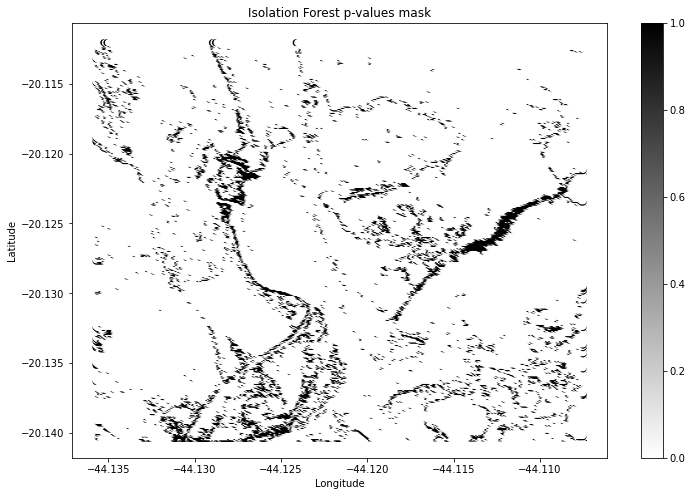

In [34]:
filtro = tab_stats_if.copy()
filtro.loc[tab_stats_if['p-valor']>0.05,'p-valor'] = 0
filtro.loc[tab_stats_if['p-valor']<0.05,'p-valor'] = 1
y = filtro.index.get_level_values(0).values
x = filtro.index.get_level_values(1).values
mask1 = filtro['p-valor'].values
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,c=mask1,marker=',',cmap='binary')
ax.set_title('Isolation Forest p-values mask')
plt.colorbar(ax.scatter(x,y,c=mask1,cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru10_NDVIIFpvalues.png')
plt.show()

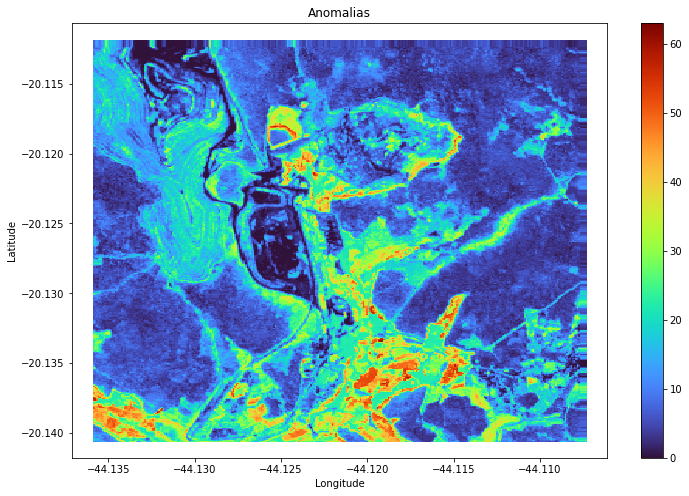

In [35]:
mask = tab_stats_if['Anomalias'].values
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,c=mask,marker=',',cmap='turbo')
ax.set_title('Anomalias')
plt.colorbar(ax.scatter(x,y,c=mask,marker=',',cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru10_NDVIIFanomalias.png')
plt.show()

#### Transform DataFrame to GeoTiff image and download!

In [36]:
def save_tiff_fromdf(df,bands,dummy,path_out):
    
    lat = []
    lon = []
    for i in range(len(df)):
        lat.append(df.index[i][0])
        lon.append(df.index[i][1])
    
    
    ulat = np.unique(lat)
    ulon = np.unique(lon)
    ncols = len(ulon)
    nrows = len(ulat)
    nbands = len(bands)
    ys = ulat[11]-ulat[10]
    xs = ulon[11]-ulon[10]
    
    arr = np.zeros([nbands, nrows, ncols], np.float32)
    refLat = np.max(ulat)
    refLon = np.min(ulon)
    for j in range(len(df)):
        posLin = np.int64( np.round( (refLat - lat[j])/ys ) )
        posCol = np.int64( np.round( (lon[j] - refLon)/xs ) )
        for b in range(nbands):
            arr[b,posLin,posCol] = df.loc[df.index[j],bands[b]]
            
    transform = (np.min(ulon),xs,0,np.max(ulat),0,-ys)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)
    
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(path_out,ncols,nrows,nbands,gdal.GDT_Float32)
    outDs.SetGeoTransform(transform)
    outDs.SetProjection(target.ExportToWkt())

    ind = 1
    for b in range(nbands):
        bandArr = np.copy(arr[b,:,:])
        outBand = outDs.GetRasterBand(ind)
        outBand.WriteArray(bandArr)
        outBand.FlushCache()
        outBand.SetNoDataValue(dummy)
        ind += 1

    outDs = None
    del outDs, outBand

    return 'ok...'

In [48]:
#precisa rodar em 15/06/2022
path_out = 'Tiff/V2_Jun22/Brumadinho_NDVI_IFAnomalies.tif'
bands = ['Anomalias','p-valor']
save_tiff_fromdf(tab_stats_if,bands,defaultDummy,path_out)
# save_tiff_fromdf(tab_stats_oc,bands,defaultDummy,path_out)

'ok...'

## NDWI Application
The process will be the same!

In [38]:
import altair as alt
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

base = alt.Chart(ndvi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y('ndwi:Q', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('ndwi:Q', title='NDVI')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

(points + lines).properties(width=600, height=350).interactive()

alt.LayerChart(...)

In [39]:
base = alt.Chart(ndvi_df).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(0, 360))))

line = base.mark_line().encode(
    y=alt.Y('median(ndvi):Q', scale=alt.Scale(domain=(0, 1))))

band = base.mark_errorband(extent='iqr').encode(
    y='ndvi:Q')

(line + band).properties(width=600, height=300).interactive()

alt.LayerChart(...)

In [40]:
listaCN = col_ajust.toList(col_ajust.size())
defaultDummy = -99999
df_ndwi = pd.DataFrame()
dias = ndvi_df['Timestamp'].values
di = {}
for j in range(col_ajust.size().getInfo()):
    tempndwi = dias[j]
    img = ee.Image(defaultDummy).blend(ee.Image(listaCN.get(j)))
    lat10, lon10, ind10 = ext_lat_lon_pixel10(img,geometria,['ndwi'])
    di[tempndwi] = ind10[0]
    
df_ndwi = df_ndwi.from_dict(di)
df_ndwi = df_ndwi.assign(Latitude = lat10)
df_ndwi = df_ndwi.assign(Longitude = lon10)
df_ndwi = df_ndwi.set_index(['Latitude','Longitude'])
df_ndwi

2016-05-07 13:14:40.000  2016-06-16 13:12:45.460  \
Latitude   Longitude                                                      
-20.140363 -44.135712                 0.054876                -0.259708   
           -44.135622                 0.015994                -0.259750   
           -44.135532                 0.032945                -0.203082   
           -44.135443                 0.032945                -0.203082   
           -44.135353                 0.024021                -0.219113   
...                                        ...                      ...   
-20.112066 -44.107864                 0.019649                -0.018953   
           -44.107775                 0.003584                -0.007695   
           -44.107685                 0.012209                 0.000664   
           -44.107595                -0.009807                -0.052863   
           -44.107505                 0.078098                -0.028794   

                       2016-06-16 13:12:45.463  2016-07-06 13:15:49.453  \
Latitude   Longitude                                                      
-20.140363 -44.135712                -0.259708                 0.011354   
           -44.135622                -0.259750                 0.018813   
           -44.135532                -0.203082                 0.034284   
           -44.135443                -0.203082                 0.034284   
           -44.135353                -0.219113                 0.027317   
...                                        ...                      ...   
-20.112066 -44.107864                -0.018953                -0.007819   
           -44.107775                -0.007695                 0.011974   
           -44.107685                 0.000664                 0.008195   
           -44.107595                -0.052863                -0.025515   
           -44.107505                -0.028794                -0.011610   

                       2016-07-26 13:12:46.455  2016-09-04 13:14:48.730  \
Latitude   Longitude                                                      
-20.140363 -44.135712             1.874842e-02                -0.038332   
           -44.135622             2.158005e-03                -0.031309   
           -44.135532             6.672791e-03                -0.022198   
           -44.135443             6.672791e-03                -0.022198   
           -44.135353             5.849400e-09                -0.015846   
...                                        ...                      ...   
-20.112066 -44.107864             2.911888e-03                 0.027270   
           -44.107775             1.038469e-02                 0.023735   
           -44.107685            -7.427261e-03                 0.044345   
           -44.107595            -4.287183e-02                 0.005683   
           -44.107505            -8.866675e-03                 0.012507   

                       2017-07-01 13:16:32.360  2017-08-30 13:12:42.460  \
Latitude   Longitude                                                      
-20.140363 -44.135712                 0.023547                -0.020031   
           -44.135622                 0.048327                -0.038421   
           -44.135532                 0.014796                -0.059228   
           -44.135443                 0.014796                -0.059228   
           -44.135353                 0.027238                -0.063160   
...                                        ...                      ...   
-20.112066 -44.107864                -0.066052                -0.016082   
           -44.107775                -0.053082                -0.052455   
           -44.107685                -0.070116                -0.048862   
           -44.107595                -0.089063                -0.077147   
           -44.107505                -0.062468                -0.074509   

                       2017-09-04 13:12:36.460  2017-10-14 13:16:26.570  ...  \
Latitude   Longitude                   

In [41]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
train = df_ndwi.values.reshape(-1,1)
classificador = IsolationForest(n_estimators=40,random_state=0,
                                n_jobs=-1,max_samples='auto').fit(train)

In [42]:
def isola(df):
    x = df.to_numpy().reshape(-1,1)
    res = classificador.predict(x)
    ser = pd.Series(res, index=df.index)
    return ser

In [43]:
ndwi_testes = pd.DataFrame(index = df_ndwi.index, columns = df_ndwi.columns)
ndwi_testes = ndwi_testes.append(df_ndwi.apply(isola, axis=1), ignore_index=False).dropna()
ndwi_testes.tail()

2016-05-07 13:14:40.000 2016-06-16 13:12:45.460  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2016-06-16 13:12:45.463 2016-07-06 13:15:49.453  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2016-07-26 13:12:46.455 2016-09-04 13:14:48.730  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2017-07-01 13:16:32.360 2017-08-30 13:12:42.460  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2017-09-04 13:12:36.460 2017-10-14 13:16:26.570  ...  \
Latitude   Longitude                                                   ...   
-20.112066 -44.107864                       1                       1  ...   
           -44.107775                       1                       1  ...   
           -44.107685                       1                       1  ...   
           -44.107595                      -1                       1  ...   
           -44.107505                       1                       1  ...   

                      2021-06-15 13:17:52.861 2021-06-25 13:17:52.413  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2021-07-10 13:17:54.848 2021-07-25 13:17:53.875  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2021-08-14 13:17:52.105 2021-08-19 13:17:54.232  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                 

In [44]:
ndwi_stats2 = pd.DataFrame()
ndwi_stats2.loc[:,'Anomalias'] = ndwi_testes.apply(contador_anomaly, axis=1)
ndwi_stats2.loc[:,'Regular'] = ndwi_testes.apply(contador_reg, axis=1)
ndwi_stats2.loc[:,'Mudanças'] = ndwi_testes.apply(transitions, axis=1)
ndwi_stats2.loc[:,'Permanece Regular'] = ndwi_testes.apply(mantem_normal, axis=1)
ndwi_stats2.loc[:,'Permanece Anomalia'] = ndwi_testes.apply(mantem_anomalia, axis=1)
ano = ndwi_stats2['Anomalias']; reg = ndwi_stats2['Regular']; mud = ndwi_stats2['Mudanças']
media = np.mean(mud)
stdev = np.std(mud)
ndwi_stats2.loc[:,'media'] = media
ndwi_stats2.loc[:,'std'] = stdev
ndwi_stats2.loc[:,'z'] = (mud - media)/stdev
ndwi_stats2.loc[:,'p-valor'] = ndwi_stats2.loc[:,'z'].apply(p_valor)
ndwi_stats2

Anomalias  Regular  Mudanças  Permanece Regular  \
Latitude   Longitude                                                     
-20.140363 -44.135712          6       59        10                 53   
           -44.135622          8       57        12                 50   
           -44.135532          7       58        12                 51   
           -44.135443          7       58        12                 51   
           -44.135353          6       59        10                 53   
...                          ...      ...       ...                ...   
-20.112066 -44.107864          4       61         8                 56   
           -44.107775          3       62         6                 58   
           -44.107685          3       62         6                 58   
           -44.107595          2       63         4                 60   
           -44.107505          2       63         4                 60   

                       Permanece Anomalia     media       std         z  \
Latitude   Longitude                                                      
-20.140363 -44.135712                   1  9.424473  4.561031  0.126184   
           -44.135622                   2  9.424473  4.561031  0.564681   
           -44.135532                   1  9.424473  4.561031  0.564681   
           -44.135443                   1  9.424473  4.561031  0.564681   
           -44.135353                   1  9.424473  4.561031  0.126184   
...                                   ...       ...       ...       ...   
-20.112066 -44.107864                   0  9.424473  4.561031 -0.312314   
           -44.107775                   0  9.424473  4.561031 -0.750811   
           -44.107685                   0  9.424473  4.561031 -0.750811   
           -44.107595                   0  9.424473  4.561031 -1.189308   
           -44.107505                   0  9.424473  4.561031 -1.189308   

                        p-valor  
Latitude   Longitude             
-20.140363 -44.135712  0.449793  
           -44.135622  0.286145  
           -44.135532  0.286145  
           -44.135443  0.286145  
           -44.135353  0.449793  
...                         ...  
-20.112066 -44.107864  0.622599  
           -44.107775  0.773617  
           -44.107685  0.773617  
           -44.107595  0.882841  
           -44.107505  0.882841  

[99540 rows x 9 columns]

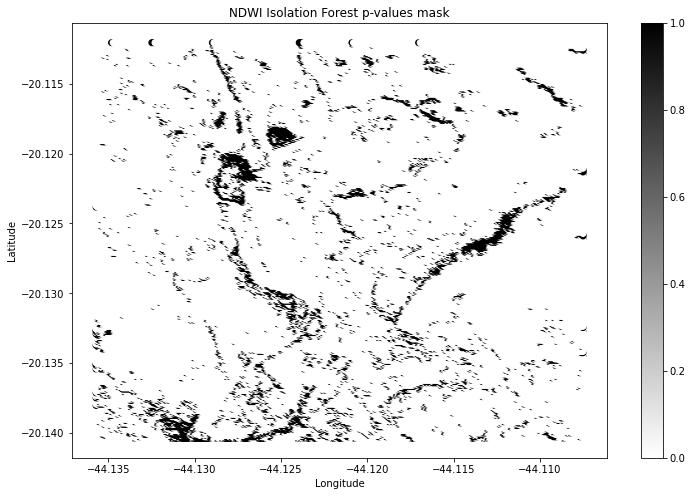

In [45]:
import matplotlib.pyplot as plt
filtrondwi = ndwi_stats2.copy()
filtrondwi.loc[ndwi_stats2['p-valor']>0.05,'p-valor'] = 0
filtrondwi.loc[ndwi_stats2['p-valor']<0.05,'p-valor'] = 1
y = filtrondwi.index.get_level_values(0).values
x = filtrondwi.index.get_level_values(1).values
mask1 = filtrondwi['p-valor'].values
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,c=mask1,marker=',',cmap='binary')
ax.set_title('NDWI Isolation Forest p-values mask')
plt.colorbar(ax.scatter(x,y,c=mask1,cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru10_NDWIIFpvalues.png')
plt.show()

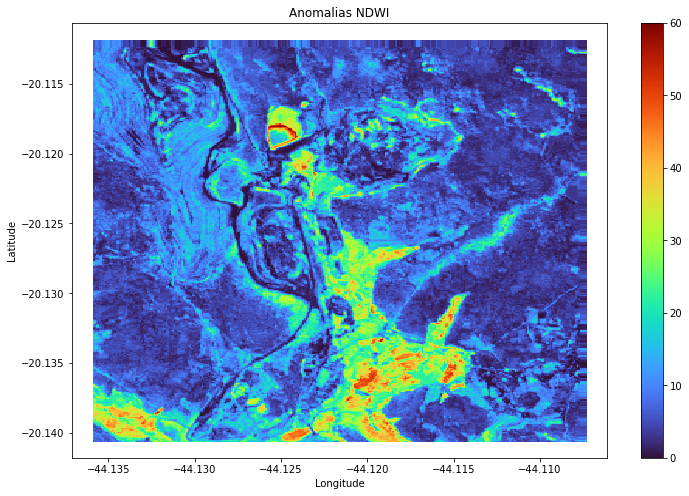

In [46]:
mask = ndwi_stats2['Anomalias'].values
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,c=mask,marker=',',cmap='turbo')
ax.set_title('Anomalias NDWI')
plt.colorbar(ax.scatter(x,y,c=mask,marker=',',cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru10_NDWIIFanomalias.png')
plt.show()

In [47]:
path_out = 'Tiff/V2_Jun22/Bru_NDWI_IF_sentinel.tif'
bands = ['Anomalias','p-valor']
save_tiff_fromdf(ndwi_stats2,bands,defaultDummy,path_out)

'ok...'

### One-Class SVM

In [49]:
oc_ndwi = df_ndwi.values.reshape(-1,1)
dpoc = np.std(oc_ndwi)
meanoc = np.mean(oc_ndwi)
print(dpoc, meanoc)

0.09735056121495719 0.0028525278154192106


In [28]:
ndwireg = []
alpha = float(input('digite o valor de α: '))
inf_lim = meanoc - alpha*dpoc
sup_lim = meanoc + alpha*dpoc
for i in oc_ndwi:
    if inf_lim < i < sup_lim:
        ndwireg.append(i)
        
arrndwi_reg = np.asarray(ndwireg)
len(arrndwi_reg)

digite o valor de α: 0.5


2640727

In [30]:
novo_data = int(0.02 * len(arrndwi_reg))
dataind = np.random.choice(len(arrndwi_reg),size=novo_data)
ndwi_data = arrndwi_reg[dataind]
len(ndwi_data)

52814

In [32]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.svm import OneClassSVM
occlf = OneClassSVM(nu=0.05).fit(ndwi_data)

def OCSVM2(df):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

In [33]:
ndwi_teste = pd.DataFrame(index = df_ndwi.index, columns = df_ndwi.columns)
ndwi_teste = ndwi_teste.append(df_ndwi.apply(OCSVM2, axis=1), ignore_index=False).dropna()
ndwi_teste.tail()

2016-05-07 13:14:40.000 2016-06-16 13:12:45.460  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                      -1   
           -44.107505                      -1                       1   

                      2016-06-16 13:12:45.463 2016-07-06 13:15:49.453  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                      -1                       1   
           -44.107505                       1                       1   

                      2016-07-26 13:12:46.455 2016-09-04 13:14:48.730  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2017-07-01 13:16:32.360 2017-08-30 13:12:42.460  \
Latitude   Longitude                                                    
-20.112066 -44.107864                      -1                      -1   
           -44.107775                      -1                      -1   
           -44.107685                      -1                      -1   
           -44.107595                      -1                      -1   
           -44.107505                      -1                      -1   

                      2017-09-04 13:12:36.460 2017-10-14 13:16:26.570  ...  \
Latitude   Longitude                                                   ...   
-20.112066 -44.107864                      -1                       1  ...   
           -44.107775                      -1                       1  ...   
           -44.107685                      -1                       1  ...   
           -44.107595                      -1                       1  ...   
           -44.107505                      -1                       1  ...   

                      2020-08-14 13:17:57.791 2020-08-19 13:17:55.491  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                       1                       1   
           -44.107505                       1                       1   

                      2020-08-29 13:17:55.218 2020-09-03 13:17:56.491  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                      -1                      -1   
           -44.107595                      -1                      -1   
           -44.107505                      -1                       1   

                      2020-09-08 13:17:54.550 2020-09-13 13:17:55.952  \
Latitude   Longitude                                                    
-20.112066 -44.107864                       1                       1   
           -44.107775                       1                       1   
           -44.107685                       1                       1   
           -44.107595                 

In [35]:
ndwi_octab = pd.DataFrame()
ndwi_octab.loc[:,'Anomalias'] = ndwi_teste.apply(contador_anomaly, axis=1)
ndwi_octab.loc[:,'Regular'] = ndwi_teste.apply(contador_reg, axis=1)
ndwi_octab.loc[:,'Mudanças'] = ndwi_teste.apply(transitions, axis=1)
ndwi_octab.loc[:,'Permanece Regular'] = ndwi_teste.apply(mantem_normal, axis=1)
ndwi_octab.loc[:,'Permanece Anomalia'] = ndwi_teste.apply(mantem_anomalia, axis=1)
ano = ndwi_octab['Anomalias']; reg = ndwi_octab['Regular']; mud = ndwi_octab['Mudanças']
media = np.mean(mud)
stdev = np.std(mud)
ndwi_octab.loc[:,'media'] = media
ndwi_octab.loc[:,'std'] = stdev
ndwi_octab.loc[:,'z'] = (mud - media)/stdev
ndwi_octab.loc[:,'p-valor'] = ndwi_octab.loc[:,'z'].apply(p_valor)
ndwi_octab

Anomalias  Regular  Mudanças  Permanece Regular  \
Latitude   Longitude                                                     
-20.140363 -44.135712         25       27        17                 18   
           -44.135622         26       26        20                 16   
           -44.135532         31       21        15                 13   
           -44.135443         31       21        15                 13   
           -44.135353         28       24        15                 16   
...                          ...      ...       ...                ...   
-20.112066 -44.107864         15       37        19                 27   
           -44.107775         18       34        19                 24   
           -44.107685         23       29        17                 20   
           -44.107595         25       27        21                 16   
           -44.107505         18       34        20                 24   

                       Permanece Anomalia      media       std         z  \
Latitude   Longitude                                                       
-20.140363 -44.135712                  16  16.940607  4.887062  0.012153   
           -44.135622                  15  16.940607  4.887062  0.626019   
           -44.135532                  23  16.940607  4.887062 -0.397091   
           -44.135443                  23  16.940607  4.887062 -0.397091   
           -44.135353                  20  16.940607  4.887062 -0.397091   
...                                   ...        ...       ...       ...   
-20.112066 -44.107864                   5  16.940607  4.887062  0.421397   
           -44.107775                   8  16.940607  4.887062  0.421397   
           -44.107685                  14  16.940607  4.887062  0.012153   
           -44.107595                  14  16.940607  4.887062  0.830641   
           -44.107505                   7  16.940607  4.887062  0.626019   

                        p-valor  
Latitude   Longitude             
-20.140363 -44.135712  0.495152  
           -44.135622  0.265651  
           -44.135532  0.654350  
           -44.135443  0.654350  
           -44.135353  0.654350  
...                         ...  
-20.112066 -44.107864  0.336733  
           -44.107775  0.336733  
           -44.107685  0.495152  
           -44.107595  0.203088  
           -44.107505  0.265651  

[99540 rows x 9 columns]

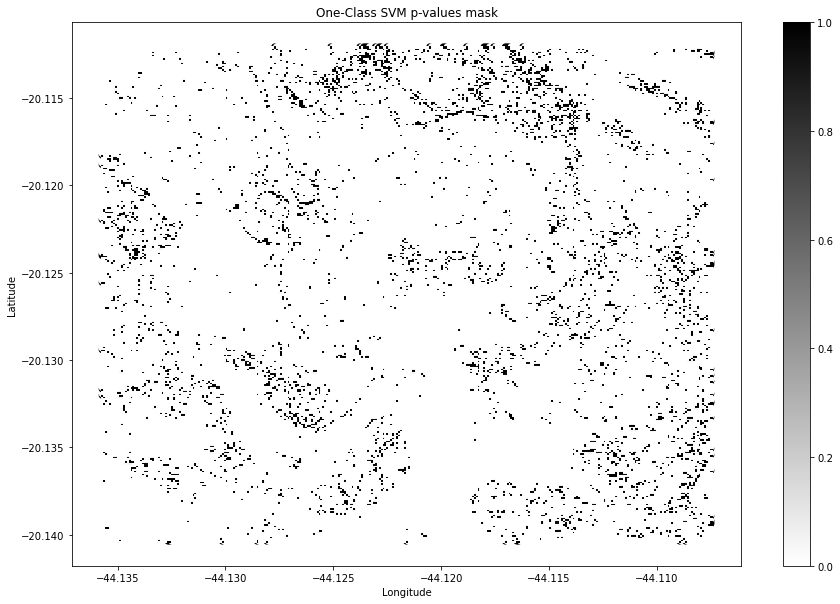

In [36]:
ft_ndwi_oc = ndwi_octab.copy()
ft_ndwi_oc.loc[ndwi_octab['p-valor']>0.05,'p-valor'] = 0
ft_ndwi_oc.loc[ndwi_octab['p-valor']<0.05,'p-valor'] = 1
x = ft_ndwi_oc.index.get_level_values(1).values
y = ft_ndwi_oc.index.get_level_values(0).values

mask2 = ft_ndwi_oc['p-valor'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask2,cmap='binary')
ax.set_title('One-Class SVM p-values mask')
plt.colorbar(ax.scatter(x,y,c=mask2,marker=',',s=2,cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_IF_pval.png')
plt.show()

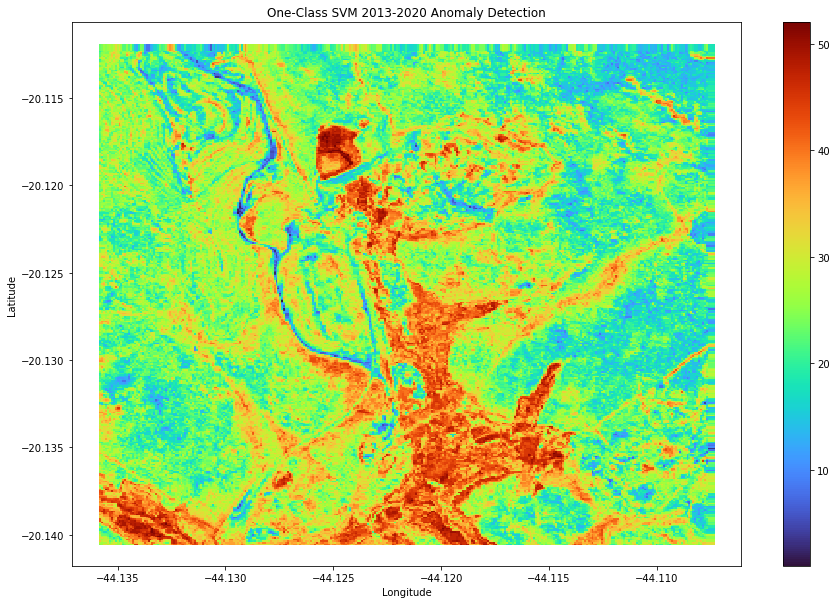

In [37]:
mask3 = ndwi_octab['Anomalias'].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=mask3,marker=',',cmap='turbo')
ax.set_title('One-Class SVM 2013-2020 Anomaly Detection')
plt.colorbar(ax.scatter(x,y,c=mask3,marker=',',cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30__NDVI_IF_anom.png')
plt.show()

In [40]:
path_out = 'Tiff//Bru_NDWI_OC_sentinel.tif'
bands = ['Anomalias','p-valor']
save_tiff_fromdf(ft_ndwi_oc,bands,defaultDummy,path_out)

'ok...'

## Application in dates of interest
### Dams break

In [49]:
df_r10.columns.values
#O INTERESSE SÃO DATAS PRÓXIMAS AO DIA 25-01-2019

array([Timestamp('2016-05-07 13:14:40'),
       Timestamp('2016-06-16 13:12:45.460000'),
       Timestamp('2016-06-16 13:12:45.463000'),
       Timestamp('2016-07-06 13:15:49.453000'),
       Timestamp('2016-07-26 13:12:46.455000'),
       Timestamp('2016-09-04 13:14:48.730000'),
       Timestamp('2017-07-01 13:16:32.360000'),
       Timestamp('2017-08-30 13:12:42.460000'),
       Timestamp('2017-09-04 13:12:36.460000'),
       Timestamp('2017-10-14 13:16:26.570000'),
       Timestamp('2017-11-13 13:14:06.870000'),
       Timestamp('2018-05-02 13:12:41.460000'),
       Timestamp('2018-05-22 13:13:30.970000'),
       Timestamp('2018-05-27 13:12:44.460000'),
       Timestamp('2018-07-01 13:12:41.460000'),
       Timestamp('2018-07-21 13:12:40.460000'),
       Timestamp('2018-08-15 13:12:42.460000'),
       Timestamp('2018-08-20 13:15:06.980000'),
       Timestamp('2018-09-09 13:12:33.460000'),
       Timestamp('2018-09-24 13:12:38.460000'),
       Timestamp('2019-01-07 13:17:50.450000'),

In [50]:
tabela_de_testes.iloc[:,15]

Latitude    Longitude 
-20.140363  -44.135712    -1
            -44.135622    -1
            -44.135532    -1
            -44.135443    -1
            -44.135353     1
                          ..
-20.112066  -44.107864    -1
            -44.107775    -1
            -44.107685    -1
            -44.107595    -1
            -44.107505    -1
Name: 2018-07-21 13:12:40.460000, Length: 99540, dtype: object

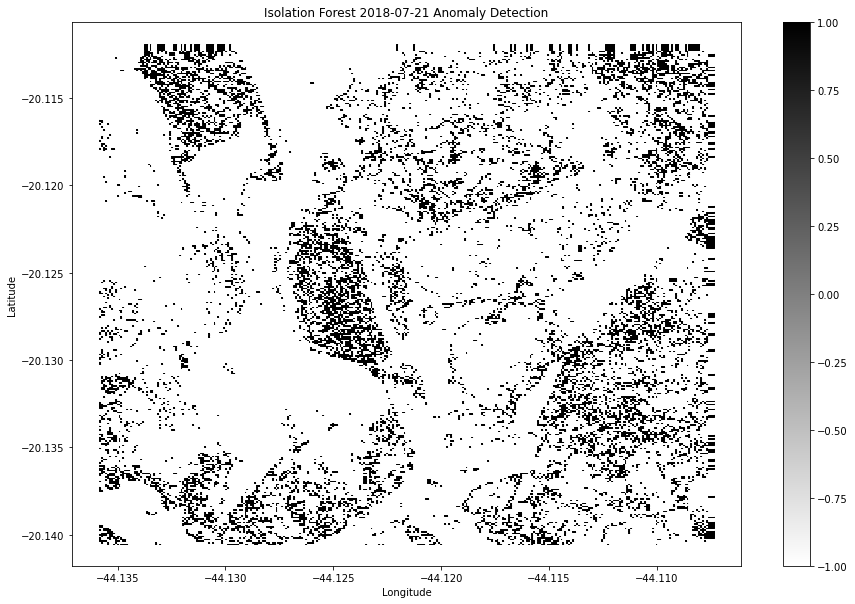

In [51]:
pre_romp = tabela_de_testes.iloc[:,15].values
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x,y,c=pre_romp,marker=',',cmap='binary')
ax.set_title('Isolation Forest 2018-07-21 Anomaly Detection')
plt.colorbar(ax.scatter(x,y,c=pre_romp,marker=',',cmap='binary'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Bru30_IFanomalias.png')
plt.show()